<a href="https://colab.research.google.com/github/sujayk96/IST597_Spring_2022/blob/main/SP21_IST597_week5_MNIST_Fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IST597:- Multi-Layer Perceptron

## Load the libraries

In [2]:
import os
import numpy as np
import time
import tensorflow as tf
np.random.seed(248)
tf.random.set_seed(248)
from sklearn.model_selection import train_test_split


In [3]:
tf.config.list_physical_devices('GPU')

[]

#Get number of Gpu's and id's in the system or else you can also use Nvidia-smi in command prompt.

## Load MNIST data

In [4]:
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.
    x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)

    x_train1, x_val, y_train1, y_val = train_test_split(x_train, y_train, test_size=0.1)
    return (x_train1, y_train1), (x_val, y_val), (x_test, y_test)

In [5]:
size_input = 784
size_hidden = [128, 64]
size_output = 10
number_of_train_examples = 60000
number_of_test_examples = 10000

In [6]:
(X_train, y_train),(X_val, y_val), (X_test, y_test) = load_data()

In [7]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(54000, 784) (54000, 10)
(6000, 784) (6000, 10)
(10000, 784) (10000, 10)


In [8]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(100)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(50)

## Build MLP using Eager Execution

In [9]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer
    # self.W0 = tf.Variable(tf.random.normal([self.size_input, self.size_input]))
    # # Initialize biases for hidden layer
    # self.b0 = tf.Variable(tf.random.normal([1, self.size_input]))
    self.W1 = tf.Variable(tf.math.multiply(tf.random.normal([self.size_input, self.size_hidden[0]]), 0.05) )
    # Initialize biases for hidden layer
    #print(self.W1)
    self.b1 = tf.Variable(tf.math.multiply(tf.random.normal([1, self.size_hidden[0]]), 0.05))
     # Initialize weights between hidden layer and output layer
    self.W2 = tf.Variable(tf.math.multiply(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]), 0.05))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.math.multiply(tf.random.normal([1, self.size_hidden[1]]), 0.05))
    self.W3 = tf.Variable(tf.math.multiply(tf.random.normal([self.size_hidden[1], self.size_output]), 0.05))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.math.multiply(tf.random.normal([1, self.size_output]), 0.05))
    # Define variables to be updated during backpropagation
    #self.variables = [self.W0, self.b0,self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

  def forward_with_dp(self, X, dp):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output_dropout(X, dp)
    else:
      self.y = self.compute_output_dropout(X, dp)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    # y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    # y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    los = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
    # print(y_true.shape)
    # print(y_pred.shape)
    # print(los)
    return los

  def loss_with_reg(self, y_pred, y_true, lambd):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    m = y_true.shape[0]
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    los = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
    # L2_regularization_cost = (tf.reduce_sum(tf.square(self.W0)) + 
    #                           tf.reduce_sum(tf.square(self.W1)) + 
    #                           tf.reduce_sum(tf.square(self.W2)) + 
    #                           tf.reduce_sum(tf.square(self.W3)))*(lambd/(2*m))
    
    L2_regularization_cost = (tf.reduce_sum(tf.square(self.W1)) + 
                              tf.reduce_sum(tf.square(self.W2)) + 
                              tf.reduce_sum(tf.square(self.W3)))*(lambd/(2*m))
    
    reg_loss = los + L2_regularization_cost
    #print(L2_regularization_cost, los, reg_loss)
    return reg_loss
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    #print(self.W1.shape)
    #t1 = self.W1
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
    #t2 = self.W1
    # print("***************************************************")
    # print(len(grads))
    # print(sum(grads[0]), sum(grads[1]), sum(grads[2]), sum(grads[3]), sum(grads[4]), sum(grads[5]))
    # print("********************************************************************")
    # print(tf.reduce_sum(self.W1))
  
  def backward_with_dropout(self, X_train, y_train,dp):
    """
    backward pass
    """
    #print(self.W1)
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
    with tf.GradientTape() as tape:
      predicted = self.forward_with_dp(X_train,dp)
      
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
    #print(self.W1)

  def backward_with_reg(self, X_train, y_train, reg):
    """
    backward pass
    """
    #print(y_train.shape)
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      
      current_loss = self.loss_with_reg(predicted, y_train, reg)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables)) 
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)

    Z0 = tf.matmul(X_tf, self.W1) + self.b1
    A0 = tf.nn.relu(Z0)
    A0 = tf.nn.batch_normalization(A0, tf.reduce_mean(A0), tf.math.reduce_variance(A0),None, None, 1e-12)
    Z1 = tf.matmul(A0, self.W2) + self.b2
    A1 = tf.nn.relu(Z1)
    A1 = tf.nn.batch_normalization(A1, tf.reduce_mean(A1), tf.math.reduce_variance(A1), None, None, 1e-12)

    Z2 = tf.matmul(A1, self.W3) + self.b3

    output = tf.nn.softmax(Z2)

    return output

  def compute_output_dropout(self, X, dp):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = (X_tf - tf.math.reduce_mean(X_tf)) / tf.math.reduce_variance(X_tf)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    ##Z0 = tf.matmul(X_tf, self.W0) + self.b0
    #A0 = tf.nn.relu(Z0)
    Z1 = tf.matmul(X_tf, self.W1) + self.b1
    A1 = tf.nn.relu(Z1)
    A1 = tf.nn.dropout(A1, dp)
    # D1 = tf.random.uniform([A1.shape[0],A1.shape[1]])
    # D1 = D1 < dp
    # A1 = tf.where(D1, A1*1.0, A1*0.0)
    # Compute output
    Z2 = tf.matmul(A1, self.W2) + self.b2
    A2 = tf.nn.relu(Z2)
    A2 = tf.nn.dropout(A2, dp)
    # D2 = tf.random.uniform([A2.shape[0],A2.shape[1]])
    # D2 = D2 < dp
    # A2 = tf.where(D2, A2*1.0, A2*0.0)
    Z3 = tf.matmul(A2, self.W3) + self.b3
    output = tf.nn.softmax(Z3)
    #print(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

## Train Model reg

In [10]:
# Set number of epochs
NUM_EPOCHS = 10
seeds = [123,4324,543,5290,9922,3456,1111,9999,8567,9944]
seeds1 = [5290]

In [13]:
history_list = []
history_test_acc_0 = []
maxpos = lambda x : np.argmax(x)

for seed in seeds: 
  history = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
    'val_loss': []
  }
  print("**********************************************************************************************************************************")
  NUM_EPOCHS = 5
  mlp_on_gpu = MLP(size_input, size_hidden, size_output, device='gpu')



  time_start = time.time()

  REG_C = 0
  reg = 0.001
  dp = 0.7
  for epoch in range(NUM_EPOCHS):
    loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(100)

    for inputs, outputs in train_ds:
      

      if REG_C == 0:
        # Loss and backward without reg
        preds = mlp_on_gpu.forward(inputs)
        loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
        
        mlp_on_gpu.backward(inputs, outputs)
        
      elif REG_C == 1:
        # Loss and backward with Regularization
        preds = mlp_on_gpu.forward(inputs)
        loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss_with_reg(preds, outputs, reg)
        mlp_on_gpu.backward_with_reg(inputs, outputs, dp)
      else:
        # Loss and backward with Backprop
        preds = mlp_on_gpu.forward_with_dp(inputs, dp)
        loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
        mlp_on_gpu.backward_with_dropout(inputs, outputs, reg)

    train_loss = np.sum(loss_total_gpu) / X_train.shape[0]  

      ###### Train accuracy
    preds = mlp_on_gpu.forward(X_train)
    yTrueMax = np.array([maxpos(rec) for rec in y_train])
    yPredMax = np.array([maxpos(rec) for rec in preds])
    train_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
    #print("Train accuracy:", train_acc)

    ######## Val loss and accuracy
    val_loss = 0
    if REG_C == 0:
      # Loss and backward without reg
      val_preds = mlp_on_gpu.forward(X_val)
      val_loss = mlp_on_gpu.loss(val_preds, y_val)
      valyTrueMax = np.array([maxpos(rec) for rec in y_val])
      valyPredMax = np.array([maxpos(rec) for rec in val_preds])
      val_acc = sum(valyPredMax == valyTrueMax)/len(valyPredMax)
      #print("val accuracy:", val_acc)        
    elif REG_C == 1:
      # Loss and backward with Regularization
      val_preds = mlp_on_gpu.forward(X_val)
      val_loss = mlp_on_gpu.loss_with_reg(val_preds, y_val)
      valyTrueMax = np.array([maxpos(rec) for rec in y_val])
      valyPredMax = np.array([maxpos(rec) for rec in val_preds])
      val_acc = sum(valyPredMax == valyTrueMax)/len(valyPredMax)
      #print("val accuracy:", val_acc) 
    else:
      # Loss and backward with Backprop
      val_preds = mlp_on_gpu.forward_with_dp(X_val)
      val_loss = mlp_on_gpu.loss(val_preds, y_val)
      valyTrueMax = np.array([maxpos(rec) for rec in y_val])
      valyPredMax = np.array([maxpos(rec) for rec in val_preds])
      val_acc = sum(valyPredMax == valyTrueMax)/len(valyPredMax)
      #print("val accuracy:", val_acc) 


    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    print('Number of Epoch = {} - Average train loss:= {} - Average val loss:= {}, Train Acc:= {}, Val acc:= {}'.format(epoch + 1, train_loss, val_loss, train_acc, val_acc))

     
       
      
  time_taken = time.time() - time_start

  print('\nTotal time taken (in seconds): {:.2f} , {}'.format(time_taken, seed))



  ##### Test Accuracy

  test_loss_total = tf.Variable(0, dtype=tf.float32)
  preds = mlp_on_gpu.forward(X_test)
  yTrueMax = np.array([maxpos(rec) for rec in y_test])
  yPredMax = np.array([maxpos(rec) for rec in preds])
  test_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
  print("Test Accuracy:", test_acc)
  history_test_acc_0.append(test_acc)

**********************************************************************************************************************************
Number of Epoch = 1 - Average train loss:= 0.005954911408600984 - Average val loss:= 0.47576647996902466, Train Acc:= 0.8265555555555556, Val acc:= 0.8278333333333333
Number of Epoch = 2 - Average train loss:= 0.004111594588668258 - Average val loss:= 0.40750032663345337, Train Acc:= 0.8551481481481481, Val acc:= 0.849
Number of Epoch = 3 - Average train loss:= 0.003702448809588397 - Average val loss:= 0.37810012698173523, Train Acc:= 0.8710925925925926, Val acc:= 0.8641666666666666
Number of Epoch = 4 - Average train loss:= 0.003391010425708912 - Average val loss:= 0.36361613869667053, Train Acc:= 0.8796481481481482, Val acc:= 0.8653333333333333
Number of Epoch = 5 - Average train loss:= 0.0032235033953631367 - Average val loss:= 0.34186360239982605, Train Acc:= 0.8897777777777778, Val acc:= 0.8748333333333334

Total time taken (in seconds): 198.90 , 123
T

In [13]:
history_test_acc_0 = [0.8644,0.8601,0.8595,0.8525,0.8547,0.8548,0.854,0.8525,0.8617,0.8573,0.858]

In [15]:
history_list_1 = []
history_test_acc_1 = []
maxpos = lambda x : np.argmax(x)

for seed in seeds: 
  history = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
    'val_loss': []
  }
  print("**********************************************************************************************************************************")
  NUM_EPOCHS = 5
  mlp_on_gpu = MLP(size_input, size_hidden, size_output, device='gpu')



  time_start = time.time()

  REG_C = 1
  reg = 0.001
  dp = 0.7
  for epoch in range(NUM_EPOCHS):
    loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(100)

    for inputs, outputs in train_ds:
      

      if REG_C == 0:
        # Loss and backward without reg
        preds = mlp_on_gpu.forward(inputs)
        loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
        
        mlp_on_gpu.backward(inputs, outputs)
        
      elif REG_C == 1:
        # Loss and backward with Regularization
        preds = mlp_on_gpu.forward(inputs)
        loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss_with_reg(preds, outputs, reg)
        mlp_on_gpu.backward_with_reg(inputs, outputs, dp)
      else:
        # Loss and backward with Backprop
        preds = mlp_on_gpu.forward_with_dp(inputs, dp)
        loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
        mlp_on_gpu.backward_with_dropout(inputs, outputs, reg)

    train_loss = np.sum(loss_total_gpu) / X_train.shape[0]  

      ###### Train accuracy
    preds = mlp_on_gpu.forward(X_train)
    yTrueMax = np.array([maxpos(rec) for rec in y_train])
    yPredMax = np.array([maxpos(rec) for rec in preds])
    train_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
    #print("Train accuracy:", train_acc)

    ######## Val loss and accuracy
    val_loss = 0
    if REG_C == 0:
      # Loss and backward without reg
      val_preds = mlp_on_gpu.forward(X_val)
      val_loss = mlp_on_gpu.loss(val_preds, y_val)
      valyTrueMax = np.array([maxpos(rec) for rec in y_val])
      valyPredMax = np.array([maxpos(rec) for rec in val_preds])
      val_acc = sum(valyPredMax == valyTrueMax)/len(valyPredMax)
      #print("val accuracy:", val_acc)        
    elif REG_C == 1:
      # Loss and backward with Regularization
      val_preds = mlp_on_gpu.forward(X_val)
      val_loss = mlp_on_gpu.loss_with_reg(val_preds, y_val, reg)
      valyTrueMax = np.array([maxpos(rec) for rec in y_val])
      valyPredMax = np.array([maxpos(rec) for rec in val_preds])
      val_acc = sum(valyPredMax == valyTrueMax)/len(valyPredMax)
      #print("val accuracy:", val_acc) 
    else:
      # Loss and backward with Backprop
      val_preds = mlp_on_gpu.forward_with_dp(X_val)
      val_loss = mlp_on_gpu.loss(val_preds, y_val)
      valyTrueMax = np.array([maxpos(rec) for rec in y_val])
      valyPredMax = np.array([maxpos(rec) for rec in val_preds])
      val_acc = sum(valyPredMax == valyTrueMax)/len(valyPredMax)
      #print("val accuracy:", val_acc) 


    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    print('Number of Epoch = {} - Average train loss:= {} - Average val loss:= {}, Train Acc:= {}, Val acc:= {}'.format(epoch + 1, train_loss, val_loss, train_acc, val_acc))

     
       
      
  time_taken = time.time() - time_start

  print('\nTotal time taken (in seconds): {:.2f} , {}'.format(time_taken, seed))



  ##### Test Accuracy

  test_loss_total = tf.Variable(0, dtype=tf.float32)
  preds = mlp_on_gpu.forward(X_test)
  yTrueMax = np.array([maxpos(rec) for rec in y_test])
  yPredMax = np.array([maxpos(rec) for rec in preds])
  test_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
  print("Test Accuracy:", test_acc)
  history_test_acc_1.append(test_acc)

**********************************************************************************************************************************
Number of Epoch = 1 - Average train loss:= 0.016973507351345486 - Average val loss:= 1.305967092514038, Train Acc:= 0.6583888888888889, Val acc:= 0.6631666666666667
Number of Epoch = 2 - Average train loss:= 0.01131911892361111 - Average val loss:= 1.0010974407196045, Train Acc:= 0.7288148148148148, Val acc:= 0.7331666666666666
Number of Epoch = 3 - Average train loss:= 0.00919563576027199 - Average val loss:= 0.8528927564620972, Train Acc:= 0.7565925925925926, Val acc:= 0.759
Number of Epoch = 4 - Average train loss:= 0.008035752473054108 - Average val loss:= 0.7622554302215576, Train Acc:= 0.7715925925925926, Val acc:= 0.7718333333333334
Number of Epoch = 5 - Average train loss:= 0.0072836241545500575 - Average val loss:= 0.7004392147064209, Train Acc:= 0.7826666666666666, Val acc:= 0.7818333333333334

Total time taken (in seconds): 201.29 , 123
Test Accu

In [15]:
history_test_acc_1 = [0.7789,0.7706,0.7731,0.7803,0.7681,0.7612,0.771,0.7696,0.7671,0.774]

In [11]:
history_list_2 = []
history_test_acc_2 = []
maxpos = lambda x : np.argmax(x)

for seed in seeds: 
  history = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
    'val_loss': []
  }
  print("**********************************************************************************************************************************")
  NUM_EPOCHS = 5
  mlp_on_gpu = MLP(size_input, size_hidden, size_output, device='gpu')



  time_start = time.time()

  REG_C = 2
  reg = 0.01
  dp = 0.7
  for epoch in range(NUM_EPOCHS):
    loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(100)

    for inputs, outputs in train_ds:
      

      if REG_C == 0:
        # Loss and backward without reg
        preds = mlp_on_gpu.forward(inputs)
        loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
        
        mlp_on_gpu.backward(inputs, outputs)
        
      elif REG_C == 1:
        # Loss and backward with Regularization
        preds = mlp_on_gpu.forward(inputs)
        loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss_with_reg(preds, outputs, reg)
        mlp_on_gpu.backward_with_reg(inputs, outputs, dp)
      else:
        # Loss and backward with Backprop
        preds = mlp_on_gpu.forward_with_dp(inputs, dp)
        loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
        mlp_on_gpu.backward_with_dropout(inputs, outputs, reg)

    train_loss = np.sum(loss_total_gpu) / X_train.shape[0]  

      ###### Train accuracy
    preds = mlp_on_gpu.forward(X_train)
    yTrueMax = np.array([maxpos(rec) for rec in y_train])
    yPredMax = np.array([maxpos(rec) for rec in preds])
    train_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
    #print("Train accuracy:", train_acc)

    ######## Val loss and accuracy
    val_loss = 0
    if REG_C == 0:
      # Loss and backward without reg
      val_preds = mlp_on_gpu.forward(X_val)
      val_loss = mlp_on_gpu.loss(val_preds, y_val)
      valyTrueMax = np.array([maxpos(rec) for rec in y_val])
      valyPredMax = np.array([maxpos(rec) for rec in val_preds])
      val_acc = sum(valyPredMax == valyTrueMax)/len(valyPredMax)
      #print("val accuracy:", val_acc)        
    elif REG_C == 1:
      # Loss and backward with Regularization
      val_preds = mlp_on_gpu.forward(X_val)
      val_loss = mlp_on_gpu.loss_with_reg(val_preds, y_val, reg)
      valyTrueMax = np.array([maxpos(rec) for rec in y_val])
      valyPredMax = np.array([maxpos(rec) for rec in val_preds])
      val_acc = sum(valyPredMax == valyTrueMax)/len(valyPredMax)
      #print("val accuracy:", val_acc) 
    else:
      # Loss and backward with Backprop
      val_preds = mlp_on_gpu.forward_with_dp(X_val, dp)
      val_loss = mlp_on_gpu.loss(val_preds, y_val)
      valyTrueMax = np.array([maxpos(rec) for rec in y_val])
      valyPredMax = np.array([maxpos(rec) for rec in val_preds])
      val_acc = sum(valyPredMax == valyTrueMax)/len(valyPredMax)
      #print("val accuracy:", val_acc) 


    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    print('Number of Epoch = {} - Average train loss:= {} - Average val loss:= {}, Train Acc:= {}, Val acc:= {}'.format(epoch + 1, train_loss, val_loss, train_acc, val_acc))

     
       
      
  time_taken = time.time() - time_start

  print('\nTotal time taken (in seconds): {:.2f} , {}'.format(time_taken, seed))



  ##### Test Accuracy

  test_loss_total = tf.Variable(0, dtype=tf.float32)
  preds = mlp_on_gpu.forward(X_test)
  yTrueMax = np.array([maxpos(rec) for rec in y_test])
  yPredMax = np.array([maxpos(rec) for rec in preds])
  test_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
  print("Test Accuracy:", test_acc)
  history_test_acc_2.append(test_acc)

**********************************************************************************************************************************
Number of Epoch = 1 - Average train loss:= 0.023052015516493055 - Average val loss:= 2.2884621620178223, Train Acc:= 0.18242592592592594, Val acc:= 0.134
Number of Epoch = 2 - Average train loss:= 0.02272915084273727 - Average val loss:= 2.2566754817962646, Train Acc:= 0.33411111111111114, Val acc:= 0.16
Number of Epoch = 3 - Average train loss:= 0.0223331140588831 - Average val loss:= 2.2060086727142334, Train Acc:= 0.44766666666666666, Val acc:= 0.17416666666666666
Number of Epoch = 4 - Average train loss:= 0.021855830439814816 - Average val loss:= 2.155648708343506, Train Acc:= 0.5017222222222222, Val acc:= 0.19133333333333333
Number of Epoch = 5 - Average train loss:= 0.021291422526041666 - Average val loss:= 2.1060802936553955, Train Acc:= 0.518074074074074, Val acc:= 0.21533333333333332

Total time taken (in seconds): 132.88 , 123
Test Accuracy: 0.510

In [17]:
print(history_test_acc_0)
print(history_test_acc_1)
print(history_test_acc_2)

[0.8644, 0.8601, 0.8595, 0.8525, 0.8547, 0.8548, 0.854, 0.8525, 0.8617, 0.8573]
[0.7789, 0.7706, 0.7731, 0.7803, 0.7681, 0.7612, 0.771, 0.7696, 0.7671, 0.774]
[0.5108, 0.4959, 0.4993, 0.5093, 0.5369, 0.5354, 0.4725, 0.4063, 0.4958, 0.4918]


In [18]:
dic = {"Normal":history_test_acc_0,
       "With reg": history_test_acc_1,
       "With dp": history_test_acc_2}

[Text(0, 0, 'Normal'), Text(0, 0, 'With reg'), Text(0, 0, 'With dp')]

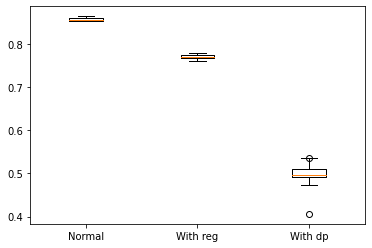

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.boxplot(dic.values())
ax.set_xticklabels(dic.keys())


In [20]:
for k,v in dic.items():
  print(k, ":   Mean: ",np.mean(v), "Variance: ", np.var(v))

Normal :   Mean:  0.8571500000000001 Variance:  1.5220499999999882e-05
With reg :   Mean:  0.77139 Variance:  2.8256900000000102e-05
With dp :   Mean:  0.49540000000000006 Variance:  0.0012244420000000007
